## Imports


In [29]:
# !pip install transformers

In [30]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter

from gensim.models import FastText

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from sklearn.metrics import accuracy_score, classification_report

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import RobertaModel, RobertaTokenizer
from concurrent.futures import ProcessPoolExecutor


# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Embedding, Flatten
from keras.utils import to_categorical

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\husse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
df = pd.read_csv('Emotional-Tone-Dataset.csv').head(4000)
df = df.drop('ID', axis=1)
df.columns = ['Text', 'Emotion']
df

,Text,Emotion
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger
2,كتنا نيله ف حظنا الهباب xD,sadness
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none
...,...,...
3995,فجاه العموم علماء فلك 😂 القمر العملاق,surprise
3996,: ياناس سفلوا فيها ودقوا خشمها بس بعيد عن هتك ...,anger
3997,لسه ملقتش اللي يحبني زي مابحبه !!,sadness
3998,0: يداعبُ عيناها سهراً يخالطه عشقاً فتبقي اسير...,love


## a) Step 1 : Preprocessing



In [32]:
# List of Arabic stopwords
arabic_stopwords = stopwords.words('arabic')

def clean_text(text):
    # Remove any non Arabic unicode
    text = re.sub(r'[^\u0600-\u06FF\s]+', ' ', text)

    # Remove username "@handle" from text
    text = re.sub(r'@\w+', '', text)

    # Remove URL from text
    text = re.sub(r'http\S+', '', text)

    # Remove punctuation, emoji, and smileys from text
    text = re.sub(r'(?<=\w)[^\s\w](?![^\s\w])', '', text)

    # Remove escape codes like \n, \t, \, etc from text
    text = re.sub(r'(\n|\t|\"|\')', '', text)

    # Remove Arabic Diacritization (tashkeel) like fatha, damma, kasra, shaddah, ...
    text = re.sub(r'[\u064B-\u0652]', '', text)

    # Tokenize the text
    words = word_tokenize(text)

    # Remove Arabic stopwords
    words = [word for word in words if word not in arabic_stopwords]

    return ' '.join(words)

# Apply the clean_text function to the 'text' column of your DataFrame
df['cleanedText'] = df['Text'].apply(clean_text)
df

,Text,Emotion,cleanedText
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...
...,...,...,...
3995,فجاه العموم علماء فلك 😂 القمر العملاق,surprise,فجاه العموم علماء فلك القمر العملاق
3996,: ياناس سفلوا فيها ودقوا خشمها بس بعيد عن هتك ...,anger,ياناس سفلوا ودقوا خشمها بعيد هتك الاعراض ربي ي...
3997,لسه ملقتش اللي يحبني زي مابحبه !!,sadness,لسه ملقتش اللي يحبني زي مابحبه
3998,0: يداعبُ عيناها سهراً يخالطه عشقاً فتبقي اسير...,love,يداعب عيناها سهرا يخالطه عشقا فتبقي اسيره صمت ...


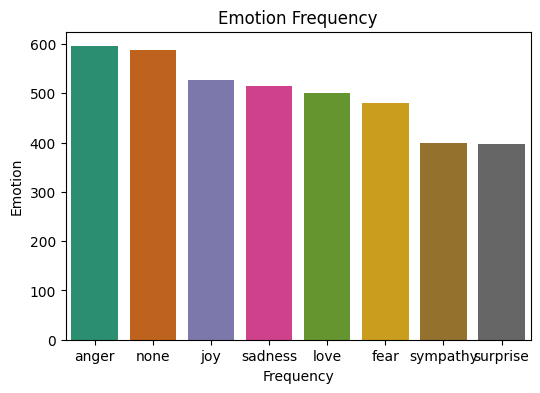

In [33]:
emotion_counts = df['Emotion'].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(x=emotion_counts.index , y=emotion_counts.values, palette=sns.color_palette('Dark2'))
plt.title('Emotion Frequency')
plt.xlabel('Frequency')
plt.ylabel('Emotion')
plt.show()

## b) Step 2: The usage of Word Embedding
+ AraBERT


In [34]:
# Load the pre-trained AraBERT tokenizer and model
AraBERT_tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")
AraBERT_model = AutoModel.from_pretrained("asafaya/bert-base-arabic")


In [35]:
# get_embeddings function to get embedding for each text
def get_embeddings(text):
    tokens = AraBERT_tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = AraBERT_model(**tokens)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [36]:
# applying get_embeddings function of text after cleaning and create a new column arabert_embeddings (to save each )
df['arabert_embeddings'] = df['cleanedText'].apply(get_embeddings)

In [37]:
df

,Text,Emotion,cleanedText,arabert_embeddings
0,الاوليمبياد الجايه هكون لسه ف الكليه ..,none,الاوليمبياد الجايه هكون لسه الكليه,"[0.23869413, -1.043507, -0.7847662, 0.30837333..."
1,عجز الموازنه وصل ل93.7 % من الناتج المحلي يعني...,anger,عجز الموازنه وصل الناتج المحلي يعني لسه اقل نف...,"[0.73096126, -0.8718648, -0.09341224, -0.41760..."
2,كتنا نيله ف حظنا الهباب xD,sadness,كتنا نيله حظنا الهباب,"[0.18826199, -0.7670665, -0.72406465, 0.006578..."
3,جميعنا نريد تحقيق اهدافنا لكن تونس تالقت في حر...,joy,جميعنا نريد تحقيق اهدافنا تونس تالقت حراسه المرمي,"[0.002712486, -0.4295182, -0.3291667, -0.24504..."
4,الاوليمبياد نظامها مختلف .. ومواعيد المونديال ...,none,الاوليمبياد نظامها مختلف ومواعيد المونديال مكا...,"[-0.21910532, -0.73481834, -0.3438832, 0.38882..."
...,...,...,...,...
3995,فجاه العموم علماء فلك 😂 القمر العملاق,surprise,فجاه العموم علماء فلك القمر العملاق,"[0.16720334, -0.93907005, -0.1658939, -0.47867..."
3996,: ياناس سفلوا فيها ودقوا خشمها بس بعيد عن هتك ...,anger,ياناس سفلوا ودقوا خشمها بعيد هتك الاعراض ربي ي...,"[0.4148718, -0.68318135, -0.46191502, 0.118134..."
3997,لسه ملقتش اللي يحبني زي مابحبه !!,sadness,لسه ملقتش اللي يحبني زي مابحبه,"[-0.29909483, -0.10008186, -0.7274346, 0.17791..."
3998,0: يداعبُ عيناها سهراً يخالطه عشقاً فتبقي اسير...,love,يداعب عيناها سهرا يخالطه عشقا فتبقي اسيره صمت ...,"[0.07729341, 0.42574477, -0.58074266, -0.58885..."


## c) Step 3: Models Development

In [38]:
X = df['arabert_embeddings'].astype(str).tolist()
y = df['Emotion']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

X_padded = pad_sequences(X_sequences)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Deep Learning Model Accuracy: {accuracy}")
print("Deep Learning Model Classification Report:\n", classification_report(y_test, y_pred))

Epoch 1/10
90/90 [==============================] - 160s 2s/step - loss: 1.7116 - accuracy: 0.3962 - val_loss: 1.4306 - val_accuracy: 0.5281
Epoch 2/10
90/90 [==============================] - 462s 5s/step - loss: 0.1426 - accuracy: 0.9774 - val_loss: 1.4796 - val_accuracy: 0.4625
Epoch 3/10
90/90 [==============================] - 186s 2s/step - loss: 0.0124 - accuracy: 0.9986 - val_loss: 1.4836 - val_accuracy: 0.5188
Epoch 4/10
90/90 [==============================] - 167s 2s/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 1.4512 - val_accuracy: 0.5125
Epoch 5/10
90/90 [==============================] - 163s 2s/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 1.4598 - val_accuracy: 0.5125
Epoch 6/10
90/90 [==============================] - 147s 2s/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 1.4265 - val_accuracy: 0.5344
Epoch 7/10
90/90 [==============================] - 131s 1s/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 1.4201 - val_accuracy: 0.5188
Epoch 8/10
90

In [40]:
# model_lstm = Sequential()
# model_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
# model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
# model_lstm.add(Bidirectional(LSTM(32)))
# model_lstm.add(Dense(64, activation='relu'))
# model_lstm.add(Dense(8, activation='softmax'))

# model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# y_pred_lstm = np.argmax(model_lstm.predict(X_test), axis=1)
# accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
# print(f"LSTM Model Accuracy: {accuracy_lstm}")
# print("LSTM Model Classification Report:\n", classification_report(y_test, y_pred_lstm))

In [41]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=X_padded.shape[1]))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(8, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_cnn = np.argmax(model_cnn.predict(X_test), axis=1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"CNN Model Accuracy: {accuracy_cnn}")
print("CNN Model Classification Report:\n", classification_report(y_test, y_pred_cnn))

Epoch 1/10
90/90 [==============================] - 149s 2s/step - loss: 2.0759 - accuracy: 0.1458 - val_loss: 2.0804 - val_accuracy: 0.1281
Epoch 2/10
90/90 [==============================] - 162s 2s/step - loss: 1.9262 - accuracy: 0.4674 - val_loss: 2.0715 - val_accuracy: 0.1219
Epoch 3/10
90/90 [==============================] - 152s 2s/step - loss: 0.6406 - accuracy: 0.9507 - val_loss: 2.0911 - val_accuracy: 0.1219
Epoch 4/10
90/90 [==============================] - 152s 2s/step - loss: 0.0154 - accuracy: 0.9983 - val_loss: 2.1734 - val_accuracy: 0.1156
Epoch 5/10
90/90 [==============================] - 151s 2s/step - loss: 0.0088 - accuracy: 0.9986 - val_loss: 2.1992 - val_accuracy: 0.1469
Epoch 6/10
90/90 [==============================] - 144s 2s/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 2.2288 - val_accuracy: 0.1156
Epoch 7/10
90/90 [==============================] - 140s 2s/step - loss: 0.0091 - accuracy: 0.9986 - val_loss: 2.2509 - val_accuracy: 0.1469
Epoch 8/10
90

c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\husse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

## d) Step 4: Testing Models

ModuleNotFoundError: No module named 'arabic_reshaper'